# Import Relevant Libraries and Create generated_images folder

In [15]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Create directory to save generated images
os.makedirs("generated_images", exist_ok=True)

# Define model hyperparameters

In [2]:
LATENT_DIM = 20  # Latent space size
INPUT_DIM = 784  # Flattened MNIST images (28x28)
BATCH_SIZE = 200
NUM_EPOCHS = 50

# Load MNIST dataset

In [3]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
train_images = train_images.astype("float32") / 255.0  # Normalize to [0,1]
test_images = test_images.astype("float32") / 255.0

# Mask the right hald of the images

In [4]:
# Function to mask the right half of an image
def mask_right_half(images):
    images = images.copy()
    images[:, :, 14:] = 0  # Set right half (columns 14-27) to black (0)
    return images

# Mask training images before feeding them into the encoder
masked_train_images = mask_right_half(train_images).reshape(-1, INPUT_DIM)
train_images = train_images.reshape(-1, INPUT_DIM)  # Keep original images for MSE computation

# Create dataset with masked images as input and original images as target
masked_dataset = tf.data.Dataset.from_tensor_slices((masked_train_images, train_images)).shuffle(60000).batch(BATCH_SIZE)

# Encoder model

In [5]:
def build_encoder():
    inputs = keras.Input(shape=(INPUT_DIM,))
    x = layers.Dense(196, activation="relu")(inputs)
    x = layers.Dense(98, activation="relu")(x)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(25, activation="relu")(x)
    z = layers.Dense(LATENT_DIM)(x)
    return keras.Model(inputs, z, name="Encoder")

# Decoder model

In [6]:
def build_decoder():
    inputs = keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(25, activation="relu")(inputs)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(98, activation="relu")(x)
    x = layers.Dense(196, activation="relu")(x)
    outputs = layers.Dense(INPUT_DIM, activation="sigmoid")(x)  # Output in range [0,1]
    return keras.Model(inputs, outputs, name="Decoder")

# Discriminator model

In [7]:
def build_discriminator():
    inputs = keras.Input(shape=(INPUT_DIM,))
    x = layers.Dense(196, activation="relu")(inputs)
    x = layers.Dense(98, activation="relu")(x)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(25, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    return keras.Model(inputs, outputs, name="Discriminator")

# Optimization Algorithm and Loss Function

In [8]:
# Instantiate models
encoder = build_encoder()
decoder = build_decoder()
discriminator = build_discriminator()

# Optimizers
ae_optimizer = keras.optimizers.Adam(learning_rate=0.001)
d_optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Loss functions
reconstruction_loss_fn = keras.losses.MeanSquaredError()
adv_loss_fn = keras.losses.BinaryCrossentropy(reduction="sum")

# Model Summary
encoder.summary()
decoder.summary()
discriminator.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         4,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,911 (702.78 KB)

 Trainable params: 179,911 (702.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │           525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 98)             │         4,998 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 196)            │        19,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 784)            │       154,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,675 (705.76 KB)

 Trainable params: 180,675 (705.76 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │         4,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,417 (700.85 KB)

 Trainable params: 179,417 (700.85 KB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

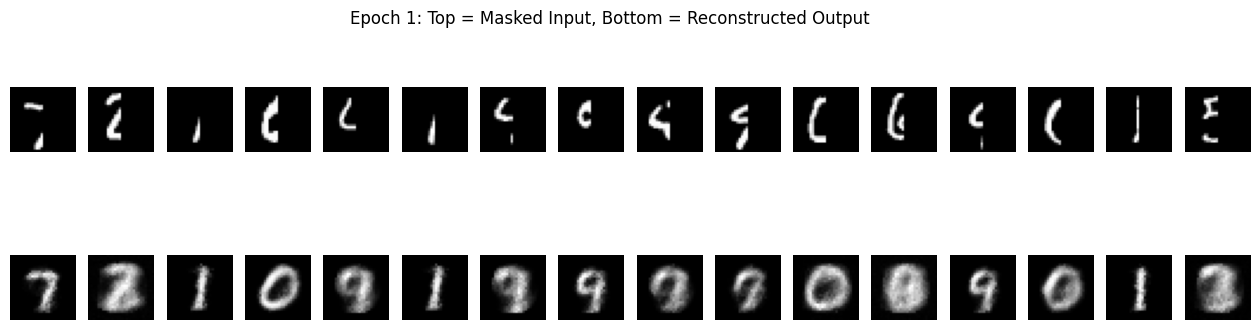

Epoch 1/50, AE Loss: 0.0500, D Loss: 9.9881
Epoch 2/50, AE Loss: 0.0355, D Loss: 32.8779
Epoch 3/50, AE Loss: 0.0313, D Loss: 5.5573
Epoch 4/50, AE Loss: 0.0298, D Loss: 12.5311
Epoch 5/50, AE Loss: 0.0278, D Loss: 2.1927


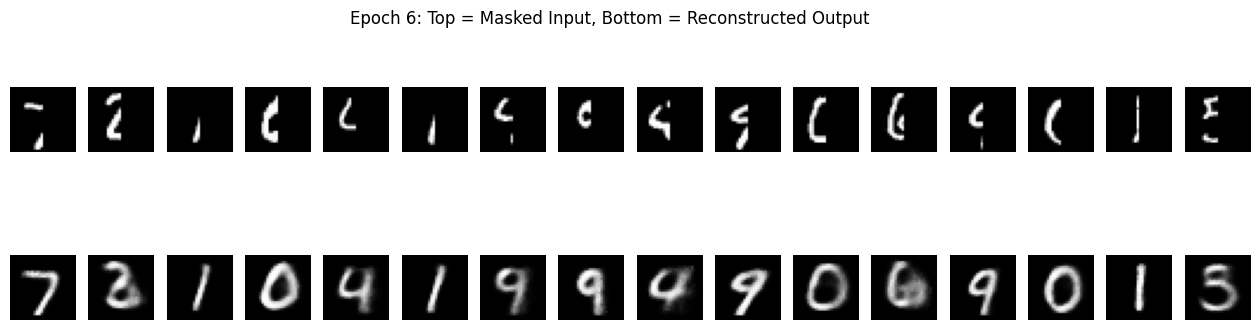

Epoch 6/50, AE Loss: 0.0273, D Loss: 1.1952
Epoch 7/50, AE Loss: 0.0270, D Loss: 1.4518
Epoch 8/50, AE Loss: 0.0273, D Loss: 6.7383
Epoch 9/50, AE Loss: 0.0252, D Loss: 0.2723
Epoch 10/50, AE Loss: 0.0251, D Loss: 7.3069


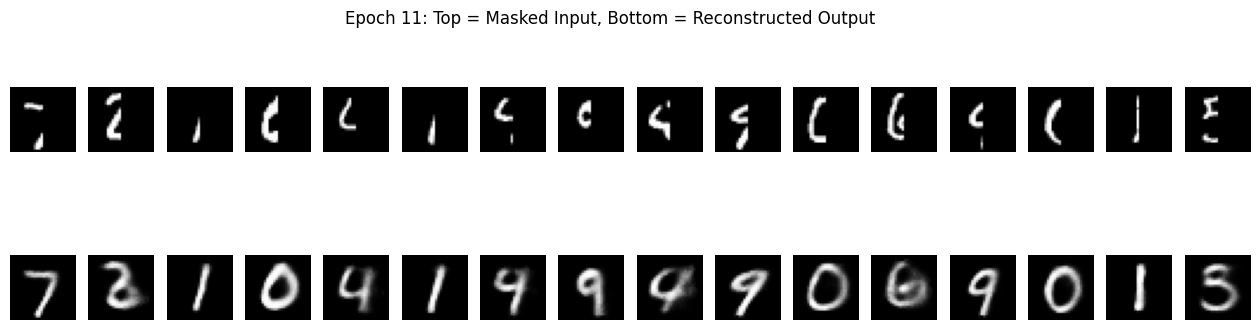

Epoch 11/50, AE Loss: 0.0232, D Loss: 4.3639
Epoch 12/50, AE Loss: 0.0241, D Loss: 7.6518
Epoch 13/50, AE Loss: 0.0233, D Loss: 3.7980
Epoch 14/50, AE Loss: 0.0227, D Loss: 1.0015
Epoch 15/50, AE Loss: 0.0247, D Loss: 1.0382


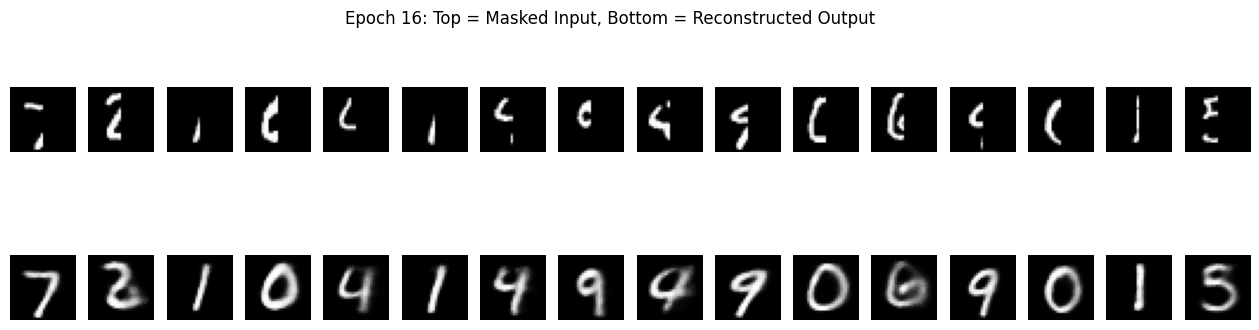

Epoch 16/50, AE Loss: 0.0238, D Loss: 0.6884
Epoch 17/50, AE Loss: 0.0217, D Loss: 0.0929
Epoch 18/50, AE Loss: 0.0222, D Loss: 3.5423
Epoch 19/50, AE Loss: 0.0225, D Loss: 2.9349
Epoch 20/50, AE Loss: 0.0229, D Loss: 0.3690


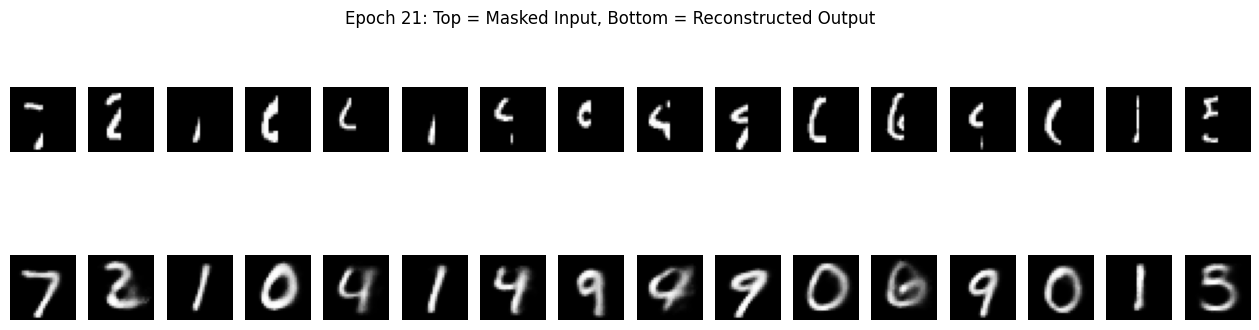

Epoch 21/50, AE Loss: 0.0228, D Loss: 1.1744
Epoch 22/50, AE Loss: 0.0211, D Loss: 0.2557
Epoch 23/50, AE Loss: 0.0218, D Loss: 0.6678
Epoch 24/50, AE Loss: 0.0208, D Loss: 6.7748
Epoch 25/50, AE Loss: 0.0215, D Loss: 0.5255


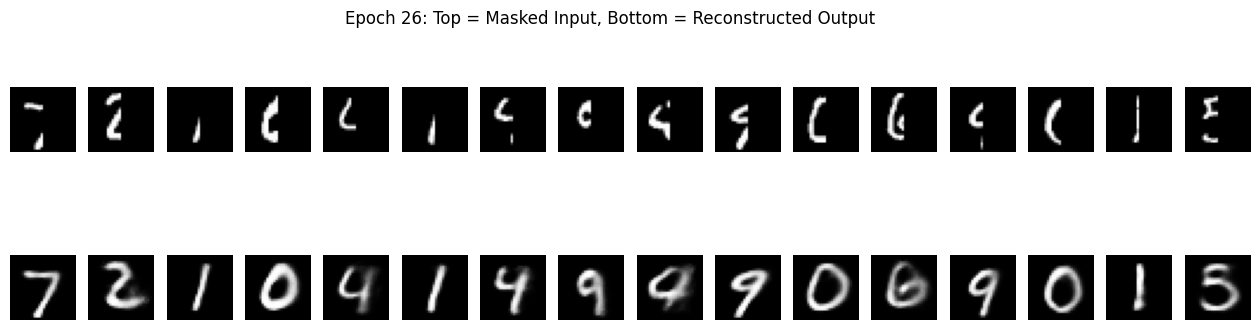

Epoch 26/50, AE Loss: 0.0216, D Loss: 5.2676
Epoch 27/50, AE Loss: 0.0206, D Loss: 0.6338
Epoch 28/50, AE Loss: 0.0216, D Loss: 0.3065
Epoch 29/50, AE Loss: 0.0196, D Loss: 2.5677
Epoch 30/50, AE Loss: 0.0206, D Loss: 1.4521


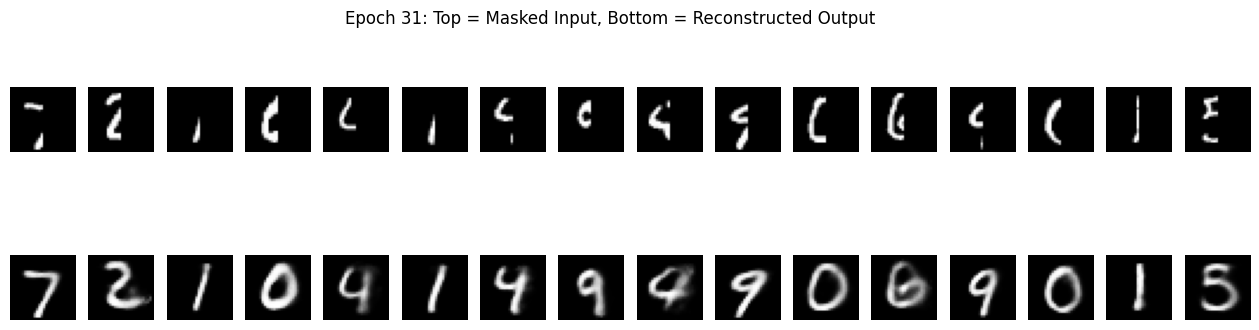

Epoch 31/50, AE Loss: 0.0206, D Loss: 0.8599
Epoch 32/50, AE Loss: 0.0206, D Loss: 2.0692
Epoch 33/50, AE Loss: 0.0219, D Loss: 1.3661
Epoch 34/50, AE Loss: 0.0197, D Loss: 0.2706
Epoch 35/50, AE Loss: 0.0203, D Loss: 0.1467


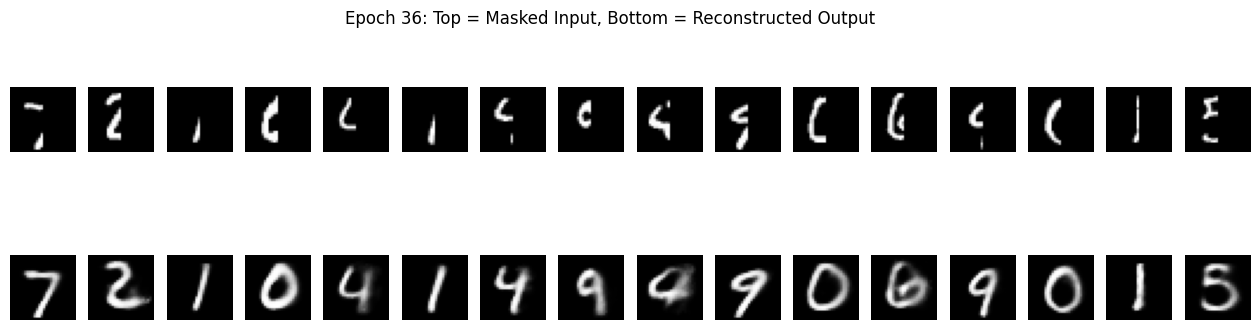

Epoch 36/50, AE Loss: 0.0207, D Loss: 1.8240
Epoch 37/50, AE Loss: 0.0202, D Loss: 0.0952
Epoch 38/50, AE Loss: 0.0202, D Loss: 0.1248
Epoch 39/50, AE Loss: 0.0184, D Loss: 0.2530
Epoch 40/50, AE Loss: 0.0189, D Loss: 2.2553


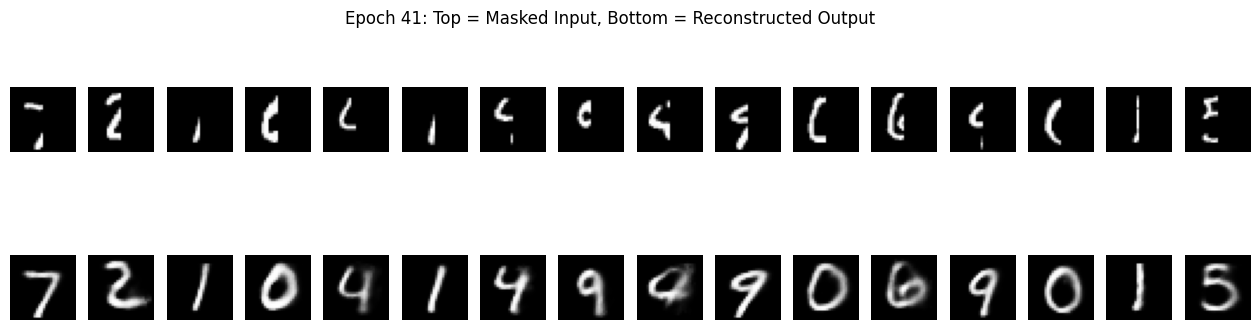

Epoch 41/50, AE Loss: 0.0199, D Loss: 0.0834
Epoch 42/50, AE Loss: 0.0203, D Loss: 4.1046
Epoch 43/50, AE Loss: 0.0195, D Loss: 4.7588
Epoch 44/50, AE Loss: 0.0198, D Loss: 0.7163
Epoch 45/50, AE Loss: 0.0191, D Loss: 0.4199


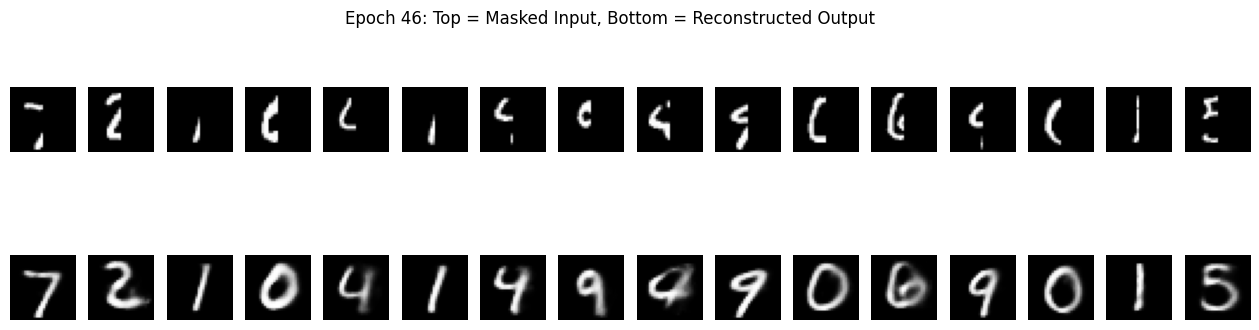

Epoch 46/50, AE Loss: 0.0190, D Loss: 0.3922
Epoch 47/50, AE Loss: 0.0202, D Loss: 0.0884
Epoch 48/50, AE Loss: 0.0187, D Loss: 0.3723
Epoch 49/50, AE Loss: 0.0176, D Loss: 0.8174
Epoch 50/50, AE Loss: 0.0196, D Loss: 5.0541


In [9]:
# Training loop
start_training_time = time.time()

for epoch in range(NUM_EPOCHS):
    for masked_batch, original_batch in masked_dataset:
        # Autoencoder step
        with tf.GradientTape() as tape:
            z = encoder(masked_batch)  # Feed masked images
            x_recon = decoder(z)  # Predict full image
            loss_ae = reconstruction_loss_fn(original_batch, x_recon)  # Compare with original
        grads = tape.gradient(loss_ae, encoder.trainable_variables + decoder.trainable_variables)
        ae_optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

        # Discriminator step
        real_labels = tf.ones((masked_batch.shape[0], 1))
        fake_labels = tf.zeros((masked_batch.shape[0], 1))
        
        with tf.GradientTape() as tape:
            d_real = discriminator(original_batch)
            d_fake = discriminator(x_recon)
            loss_d = adv_loss_fn(real_labels, d_real) + adv_loss_fn(fake_labels, d_fake)
        grads = tape.gradient(loss_d, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        # Select sample images
        sample_masked_imgs = mask_right_half(test_images[:16])  # Masked input
        sample_masked_imgs_flat = sample_masked_imgs.reshape(-1, INPUT_DIM)
    
        # Generate images from autoencoder
        sample_z = encoder(sample_masked_imgs_flat, training=False)
        generated_images = decoder(sample_z, training=False).numpy().reshape(16, 28, 28)
    
        # Plot both masked input and reconstructed output
        fig, axes = plt.subplots(2, 16, figsize=(16, 4))  # 2 rows, 16 columns
    
        for i in range(16):
            # Show masked input in first row
            axes[0, i].imshow(sample_masked_imgs[i], cmap='gray')
            axes[0, i].axis('off')
    
            # Show reconstructed output in second row
            axes[1, i].imshow(generated_images[i], cmap='gray')
            axes[1, i].axis('off')
        plt.suptitle(f"Epoch {epoch+1}: Top = Masked Input, Bottom = Reconstructed Output")
        plt.savefig(f"generated_images/epoch_{epoch+1}.png")  # Save as PNG
        plt.show()  # Display the images
        plt.close()

        

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, AE Loss: {loss_ae:.4f}, D Loss: {loss_d:.4f}")

training_time = time.time() - start_training_time

# Evaluate the trained model

In [35]:
# Mask right half and reshape for evaluation
sample_masked_test = mask_right_half(test_images).reshape(-1, INPUT_DIM)
sample_test_images = test_images.reshape(-1, INPUT_DIM)
adv_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction="sum")

# Start inference time tracking
start_inference_time = time.time()

# Encode and decode
sample_z = encoder(sample_masked_test, training=False)
generated_images = decoder(sample_z, training=False).numpy().reshape(-1, INPUT_DIM)

# Compute inference time
inference_time = time.time() - start_inference_time

# Compute Mean Squared Error (MSE) loss
mse_loss = reconstruction_loss_fn(sample_test_images, generated_images).numpy()

# Compute Binary Cross-Entropy (BCE) Loss
real_labels = tf.ones((sample_masked_test.shape[0], 1))
fake_labels = tf.zeros((sample_masked_test.shape[0], 1))

d_real = discriminator(sample_test_images)
d_fake = discriminator(generated_images)

bce_loss = adv_loss_fn(real_labels, d_real) + adv_loss_fn(fake_labels, d_fake)

# Compute Classification Error
real_preds = discriminator(sample_test_images, training=False)
fake_preds = discriminator(generated_images, training=False)

real_acc = tf.reduce_mean(tf.cast(real_preds > 0.5, tf.float32))
fake_acc = tf.reduce_mean(tf.cast(fake_preds < 0.5, tf.float32))
classification_error = 1.0 - (real_acc + fake_acc) / 2

# Log-Likelihood Approximation
z_mean = np.mean(sample_z, axis=0)  # Mean vector of shape [latent_dim]
z_cov = np.cov(sample_z, rowvar=False)  # Covariance matrix of shape [latent_dim, latent_dim]


# Compute log-likelihood of each sample
log_likelihoods = multivariate_normal.logpdf(sample_z, mean=z_mean, cov=z_cov)

# Average log-likelihood
avg_log_likelihood = np.sum(log_likelihoods)/sample_z.shape[0]

# Display the results

In [ ]:
# Print results
print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.4f}s")
print(f"Final MSE Loss: {mse_loss:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Classification Error: {classification_error:.4f}")
print(f"Log-Likelihood (approx.): {avg_log_likelihood:.4f}")

Training Time: 2500.73 seconds
Inference Time: 0.0499s
Final MSE Loss: 0.0204
BCE Loss: 274.0343
Classification Error: 0.0040
Log-Likelihood (approx.): -24.7528
